# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [17]:
import twitter
from itertools import ifilter, imap
import sys
from twitter.api import RateLimit, TwitterError
from time import sleep
import string
from nltk.tokenize import TweetTokenizer
from itertools import ifilter, imap
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import os
import json
import re
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer
from requests.exceptions import ConnectionError
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.misc import imread
from time import time

In [18]:

CONSUMER_KEY = "ugobTj1J8YbCQoyNrDIucjOPX"
CONSUMER_SECRET = "eWBVA7VJfKYywSbAqe9tQJw50dHQvyLJCacFBoIs2dd2CkNTgY"

ACCESS_TOKEN_KEY = "781167349399490562-WLDzou6ho6w8yVLTKbrEPT0bdq0wSfg"
ACCESS_TOKEN_SECRET = "vrTd7102GIFrUAmNVHKJNn8wsqhGND2cTaaeKVjwsq8jO"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [30]:
#https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/
def getTrashRemover(remove_hash_tags= False, remove_hash_sign = False):
    emoticons_str = r"""
    (?:
        [:=;] 
        [oO\-]? 
        [D\)\]\(\]/\\OpP] 
    )"""
    # Eyes # Nose (optional) # Mouth
    regex_str = [
        emoticons_str,
        r'<[^>]+>', # HTML tags
        r'(?:@[\w_]+)\:?', # @-mentions
        r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
        r'(?:(?:\d+,?)+(?:\.?\d+)?)' # numbers
        #r'(?:\S)' # anything else
    ]
    if remove_hash_tags:
        regex_str.append( r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)")# hash-tags
    elif remove_hash_sign:
        regex_str.append(r"\#")
    def remove_url_and_users(text, trash = re.compile(r'('+'|'.join(regex_str)+')', 
                                                      flags = re.VERBOSE | re.IGNORECASE | re.UNICODE) ):
        return trash.sub(" ", text)

    return remove_url_and_users


def isUnofficialTweet(text, regex = re.compile(r"\s*RT\s* \@", flags = re.VERBOSE | re.IGNORECASE | re.UNICODE)):
    return True if regex.match(text) else False

#http://stackoverflow.com/questions/29689566/exclude-retweets-from-twitter-streaming-api-using-tweepy


In [54]:
remove_url_and_users = getTrashRemover()

def calcLimit():
    api.rate_limit = None
    api.InitializeRateLimit()
    print api.CheckRateLimit("/statuses/user_timeline")
    rg = api.CheckRateLimit("/statuses/user_timeline").reset - time()
    return rg + 1 if rg > 0 else 1

calcLimit()

def get_user_tweets(user_id, rmUnOfTweets = True):
    """returns iterator of tweets as dicts"""
    try:
        user_tweet_list = api.GetUserTimeline(user_id = user_id, count = 200, 
                            exclude_replies = True, include_rts = False)
    except TwitterError as e:
        if e.message == "Exceeded connection limit for user":
            limit = calcLimit()
            #sys.stderr.write("Have got error: '{}'.Waiting for {}\n".\
            #    format(e.message, limit))
            sleep(limit)
            user_tweet_list = api.GetUserTimeline(user_id = user_id, count = 200, 
                exclude_replies = True, include_rts = False)
        elif e.message == "Not authorized.":
            user_tweet_list = []
            #sys.stderr.write("User is unathorized\n")
        elif isinstance(e.message, list) and u"message" in e.message[0] and\
            e.message[0][u'message'] == u"Sorry, that page does not exist.": # RIP
            user_tweet_list = []
            #sys.stderr.write("User is not exist\n")
        elif isinstance(e.message, list) and u"message" in e.message[0] and\
            e.message[0][u'message'] == u'Rate limit exceeded':
            limit = calcLimit()
            print api.rate_limit.get_limit("/statuses/user_timeline")
            #sys.stderr.write("Have got error: '{}'.Waiting for {}\n".\
            #    format(e.message, limit))
            sleep(limit)
            user_tweet_list = api.GetUserTimeline(user_id = user_id, count = 200, 
                exclude_replies = True, include_rts = False)
        else:
            #sys.stderr.write("Get unexpected Twitter error '{}'\n".
            #                format(e.message))
            raise TwitterError(e.message)
    except ConnectionError as ce:
        #sys.stderr("Possibly exceeded connection limit for user. ")
        limit = calcLimit()
        #sys.stderr.write("Waiting for {}\n".format(limit))
        sleep(limit)
        user_tweet_list = api.GetUserTimeline(user_id = user_id, count = 200, 
                exclude_replies = True, include_rts = False)    
    if user_tweet_list:
        user_tweet_list = ifilter(lambda x: x.lang == "en", user_tweet_list)
        user_tweet_list = ifilter(lambda x : x.text.strip() != u"", user_tweet_list)
        if rmUnOfTweets:
            user_tweet_list = ifilter(lambda x : not isUnofficialTweet(x.text), user_tweet_list)
        user_tweet_list = ( {'lang' : u'en',
                        'favorited' : x.favorited,
                        'trucated' : x.truncated,
                        'text' : remove_url_and_users(x.text),
                        'created_at' : x.created_at,
                       'retweeted': x.retweeted,
                        'source' : x.source,
                        'user' : {'id' : x.user.id},
                        'id' : x.id} for x in user_tweet_list)
        user_tweet_list = ifilter(lambda x : x['text'].strip() != u"", user_tweet_list)
    
    return user_tweet_list

EndpointRateLimit(limit=900, remaining=264, reset=1479685131)


## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.


Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [32]:
def remove_punctuation(text, regex = re.compile(r"[^\w-]|(?<!\w)-(?!\w)", flags = re.VERBOSE | re.IGNORECASE | re.UNICODE)):
    return regex.sub(" ", text)

def get_words(text,  tknzr = TweetTokenizer(preserve_case = False, strip_handles=True, reduce_len=False)):
    """returns iterator of words"""
    return ifilter(lambda x : x != ":", tknzr.tokenize(remove_punctuation(text)))
    # : means, that twt substitute smth like @andrew by :

    # your code here

In [33]:
print list(get_words("Here are different words!"))

[u'here', u'are', u'different', u'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [34]:
import nltk
#nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [35]:
## for correct lemmatizer work

from nltk.corpus import brown
brown_tagged_sents = brown.tagged_sents()
brown_sents = brown.sents()
unigram_tagger = nltk.UnigramTagger(brown_tagged_sents)

In [36]:
#http://stackoverflow.com/questions/25534214/nltk-wordnet-lemmatizer-shouldnt-it-lemmatize-all-inflections-of-a-word
from nltk.corpus import wordnet as wn

def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']


def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return wn.NOUN # just to avoid raising error

In [37]:
from nltk import pos_tag
from nltk.corpus import brown

def get_tokens(words, stopwords = stopwords.words('english'), lemma = WordNetLemmatizer()):
    """returns iter of tokens"""
    main_words = [x for x in words if x not in stopwords]
    return (lemma.lemmatize(x,penn_to_wn(y)) for (x,y) in unigram_tagger.tag(main_words))
    



In [38]:
print list(get_tokens(["here", "are", "different", "words", "gone", "loving"]))
print list(get_tokens( ['colorless','ideas','sleep','furiously']))

['different', u'word', u'go', u'love']
['colorless', u'idea', 'sleep', 'furiously']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [39]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(remove_url_and_users(tweet)))

print " ".join(list(get_tweet_tokens("New-York was visited by Trump")))

new-york visit trump


Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [40]:
def collect_users_tokens(df_users, save_period = 15, temp_file_name = "users_info.json"):
    id_list = df_users['uid']
    info_dict = dict()
    part_dict = dict()
    if os.path.isfile(temp_file_name):
        with open(temp_file_name, "r") as temp_file:
            for line in temp_file:
                info_dict.update(json.loads(line))

    for user_id in id_list:
        if str(user_id) in info_dict:
            #sys.stdout.write("Information for user {} had already collected\n".format(user_id))
            continue
        #sys.stdout.write("Collecting info for user {} ...".format(user_id))
        
        freq = Counter()
        for tweet in get_user_tweets(user_id):
            freq += Counter(get_tweet_tokens(tweet['text']))
        part_dict[user_id] = freq
        
        #sys.stdout.write(" Done\n")
        if len(part_dict) == save_period:
            info_dict.update(part_dict)
            #sys.stdout.write("Saving intermediate results ...")
            with open(temp_file_name, "a") as temp_file:
                temp_file.write(json.dumps(part_dict) + "\n")
            part_dict = dict()
            #sys.stdout.write(" Done\n")
    # save intermediate result
    if len(part_dict) > 0:
        info_dict.update(part_dict)
        #sys.stdout.write("Saving intermediate results ...")
        with open(temp_file_name, "a") as temp_file:
            temp_file.write(json.dumps(part_dict) + "\n")
        part_dict = dict()
        #sys.stdout.write(" Done\n")
    return info_dict.keys(), info_dict.values()


In [41]:



TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])


users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

In [16]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [116]:
from os import path

def draw_tag_cloud(v, vs):
    tokens = v.get_feature_names()
    freq = np.sum(vs, axis = 0, keepdims = False)
    freq = np.array(freq)[0]
    mask = imread("cat_mask.jpg")
    pos = np.argpartition(freq, -100)[-100:]
    wc = WordCloud(max_words=200, relative_scaling = 0.5, mask = mask)
    freqtuple = [(tokens[i], freq[i]) for i in pos]
    wc.generate_from_frequencies(freqtuple)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    return

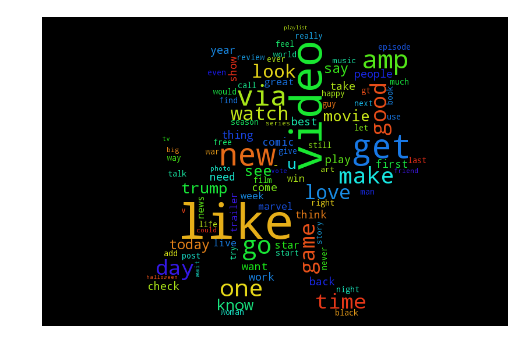

In [117]:
draw_tag_cloud(v, vs)
